In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

# import lightgbm as lgbm

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

### 3.1: Getting Data and setting up Kaggle

In [3]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

### 3.2 : Preprocessing the Data

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log1p
  from ipykernel import kernelapp as app


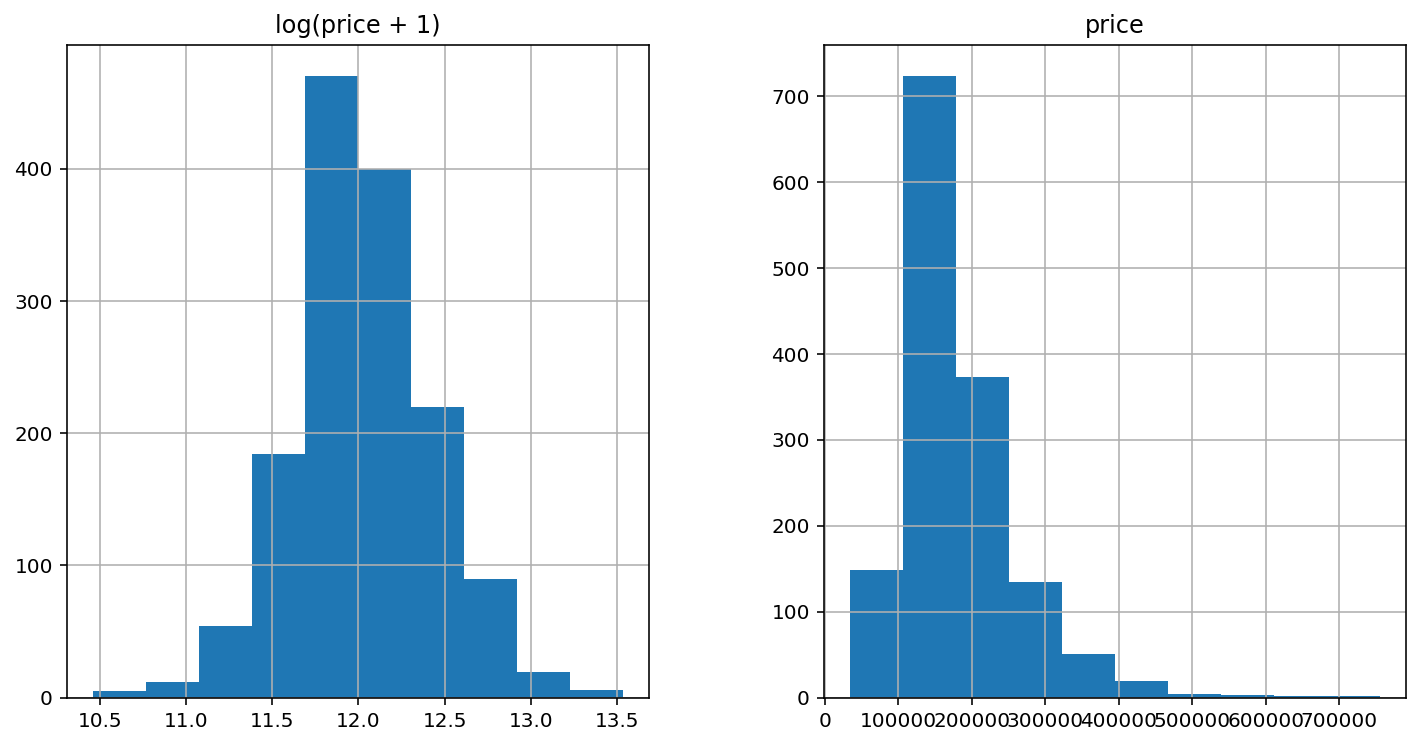

In [4]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

all_data = all_data.fillna(all_data.mean())

In [38]:
# Creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [6]:
# Cross validation RMSE function
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [7]:
# Ridge Regression with alpha=0.1
ridgeModel = Ridge(alpha=0.1)

# Score for alpha=0.1 Ridge Regression - With cross validation among 5 bins
cv_ridge = rmse_cv(ridgeModel).mean()
print(cv_ridge)

0.13777538277187878


In [8]:
# Score for alpha=0.1 Ridge Regression - No cross validation
ridgeModel.fit(X_train,y)
pred=ridgeModel.predict(X_train)
rmse_ridge = np.sqrt(mean_squared_error(y,pred))
print(rmse_ridge)

0.09211955585640513


In [9]:
# Prediction on Test set using Ridge Model with alpha=0.1
pred = ridgeModel.predict(X_test)
np.expm1(pred)

array([121519.48656871, 159637.89835116, 187900.72801905, ...,
       176763.91404077, 121610.54954924, 219174.15546004])

In [10]:
# For Submission to Kaggle
# Single Ridge Regression

ids = test['Id']
yfinalpred = ridgeModel.predict(X_test)
sale_prices = np.expm1(yfinalpred)

result = pd.DataFrame({ 'Id': ids, 'SalePrice': np.round(sale_prices, 3) })
display(result.head())

result.to_csv('submission.csv', header=['Id', 'SalePrice'], index=False)

,Id,SalePrice
0,1461,121519.487
1,1462,159637.898
2,1463,187900.728
3,1464,200719.158
4,1465,199280.935


### RMSE Score of 0.13029 on Kaggle.

### 3.3: Comparing Lasso and Ridge Regression

Ridge and Lasso regression done as single iteration and with cross-validation.

Observation: Lesser RMSE error in Lasso on account of its selecting the features that have most impact on label.

In [11]:
# Cross validation with Lasso regression model and 5 different alpha values
lassoModelCV = LassoCV(alphas = [5, 1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(lassoModelCV).mean()


/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 

0.12314421090977432

In [12]:
# Cross validation with Ridge regression model and 5 different alpha values
ridgeModelCV = RidgeCV(alphas = [5, 1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(ridgeModelCV).mean()

0.1278217968244439

In [13]:
# Single Lasso Regression
lassoModel = Lasso(alpha=.1)
lassoModel.fit(X_train,y)
pred=lassoModel.predict(X_train)
rmse_lasso = np.sqrt(mean_squared_error(y,pred))
print(rmse_lasso)

0.20753905105566584


In [14]:
# R2 Score calculation against given training dataset
yrpred=ridgeModel.predict(X_train)
r2_score_ridge = r2_score(y, yrpred)
print("Ridge - R^2 on test data : %f" % r2_score_ridge)

ylpred=lassoModel.predict(X_train)
r2_score_lasso = r2_score(y, ylpred)
print("Lasso - R^2 on test data : %f" % r2_score_lasso)


Ridge - R^2 on test data : 0.946780
Lasso - R^2 on test data : 0.729869


### 3.4: L0 Norm of Lasso Regression

L0 Norm is essentially the non-zero coefficients of a Lasso regression. Since Lasso nullifies or makes zero a few coefficients that are irrelevant l0 norm gives the number of coeeficients that are the most significant for the regression.

In [15]:
# Getting coefficients of Lasso regression model
coef = pd.Series(lassoModel.coef_, index = X_train.columns)

# L0 Norm for alpha=0.1 - non-zero coefficients after applying Lasso model
sum(coef != 0)

8

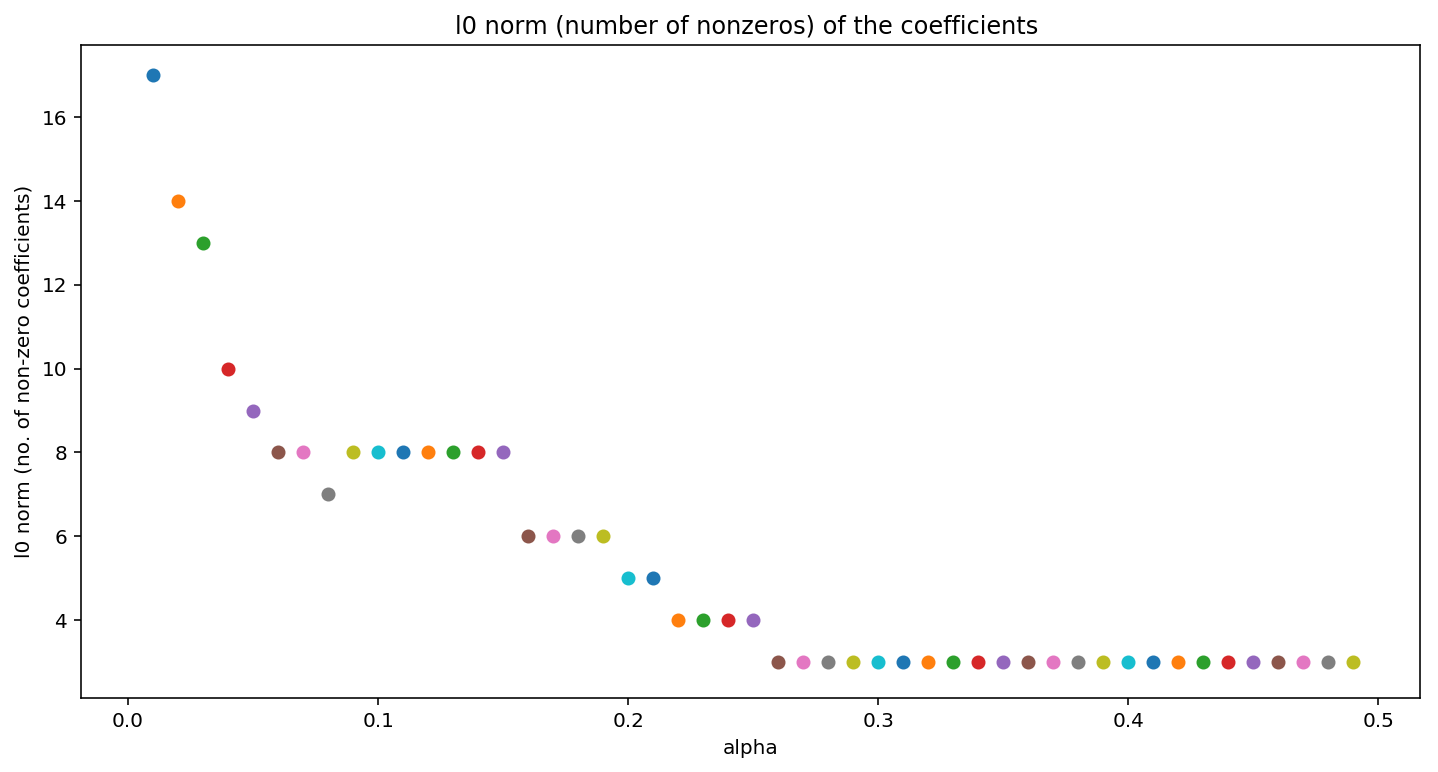

In [16]:
# Plotting the different L0 norm values for a range of alpha values

alphas = [i for i in np.arange(0.01,0.5,0.01)]
for alpha in alphas:
    lassoModel = Lasso(alpha=alpha)
    lassoModel.fit(X_train,y)
    coef = pd.Series(lassoModel.coef_, index = X_train.columns)
    x_sum = sum(coef != 0)
    plt.scatter(alpha,x_sum)
plt.title("l0 norm (number of nonzeros) of the coefficients ")
plt.xlabel("alpha")
plt.ylabel("l0 norm (no. of non-zero coefficients)")
plt.show()

We observe that with increasing value of alpha, the number of non-zero coefficients decreases, which is what regularization does, simplifies the features by elimination in case of Lasso model.

### 3.5: Ensembling and Stacking with Ridge and Lasso Regression

For ensembling and stacking we have appended the predicted Y values from Lasso and Ridge as two extra columns to our dataset and applied Ridge regression on the whole dataset of features and two y columns. This has given a slightly better R<sup>2</sup> Score.

In [15]:
# Appending the model outputs of Lasso and Ridge regressions onto dataset
new_X_train = X_train.copy()

new_X_train['LassoPred']=ylpred
new_X_train['RidgePred']=yrpred

In [16]:
new_X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LassoPred,RidgePred
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,1,0,0,0,0,1,0,12.325995,12.241886
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,1,0,0,0,0,1,0,11.990494,12.183406
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,1,0,0,0,0,1,0,12.284779,12.286281
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,1,1,0,0,0,0,0,11.956719,12.010263
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,1,0,0,0,0,1,0,12.578413,12.595739


In [17]:
# Applying Ridge model to stacked dataset

stack_ridgeModel = Ridge(alpha=.1)
stack_ridgeModel.fit(new_X_train,y)
y_ridgestack_pred=stack_ridgeModel.predict(new_X_train)
y_ridgestack_pred

array([12.24302003, 12.18578078, 12.28674395, ..., 12.55522042,
       11.86530384, 11.85771499])

In [18]:
r2_score_stack_ridge = r2_score(y, y_ridgestack_pred)
print("Stacked Ridge - R^2 on data : %f" % r2_score_stack_ridge)
print("Previous Ridge - R^2 on data : %f" % r2_score_ridge)

Stacked Ridge - R^2 on data : 0.947086
Previous Ridge - R^2 on data : 0.946780


Stacking the predicted outputs from Lasso and Ridge models on top of our dataset has given a slightly better R<sup>2</sup> Score meaning more of the variance is accounted for in this stacked Ridge Regression model.

In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [20]:
model=XGBRegressor()
model.fit(X_train,y)
pred=model.predict(X_train)
rmse_xgb = np.sqrt(mean_squared_error(y,pred))
print(rmse_xgb)

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:48:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.08659972559779022


### 3.6: Gradient Boosting Regressor - XGBoost

In [100]:
xgb1 = XGBRegressor(random_state=1)
xgb1.fit(X_train.values,y.values)
print("XGBoost: ",np.sqrt(-cross_val_score(xgb1, X_train.values, y, scoring="neg_mean_squared_error", cv = 5)).mean())
print("RidgeCV: ",np.sqrt(-cross_val_score(RidgeCV(alphas = [5, 1, 0.1, 0.001, 0.0005]), X_train.values, y, scoring="neg_mean_squared_error", cv = 5)).mean())
print("LassoCV: ",np.sqrt(-cross_val_score(LassoCV(alphas = [5, 1, 0.1, 0.001, 0.0005]), X_train.values, y, scoring="neg_mean_squared_error", cv = 5)).mean())

[14:53:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost:  0.13082901229236588
RidgeCV:  0.1278217968867192
LassoCV:  0.12314421090977445


### Tuning parameters of Gradient Boosting Regressor - XGBoost

In [101]:
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [0.05],
              'max_depth': [3],
              'min_child_weight': [3],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.3],
              'n_estimators': [700,800]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True, scoring='neg_mean_absolute_error')

xgb_grid.fit(X_train,y)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  9.4min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 30.6min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 47.8min
[Parallel(n_jobs=5)]: Done 960 out of 960 | elapsed: 53.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=1,...
             iid='warn', n_jobs=5,
             param_grid={'colsample_bytree': [0.5, 0.3],
                         'learning_rate': [0.05, 0.01], 'max_depth': [3, 5],
                         'min_child_weight': [4, 3],
                         'n_estimators': [700, 600, 500],
                         'objective': ['reg:linear', 'reg:squarederror'],
         

In [102]:
print(xgb_grid.best_params_)

{'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 700, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [109]:
ypred=xgb_grid.predict(X_train)
print("XGBoost GridSearch: ",np.sqrt(mean_squared_error(y,ypred)))


XGBoost GridSearch:  0.0582259107165745


### Best Parameters - 

random_state=0,learning_rate=0.05,n_estimators=700,max_depth=3, colsample_bytree=0.3, min_child_weight=3, objective='reg:squarederror'

In [125]:
# XGBRegressor with best parameters
xgb2 = XGBRegressor(random_state=0,learning_rate=0.05,n_estimators=700,max_depth=3, colsample_bytree=0.3, min_child_weight=3, objective='reg:squarederror')
xgb2.fit(X_train,y)
print("XGBoost Tuned: ",np.sqrt(-cross_val_score(xgb2, X_train.values, y, scoring="neg_mean_squared_error", cv = 5)).mean())

XGBoost Tuned:  0.11938125507183402


### 3.7 Stacking and Ensembling with XGBRegressor

In [113]:
xgb2 = XGBRegressor(random_state=0,learning_rate=0.05,n_estimators=1000,max_depth=3, colsample_bytree=0.3, min_child_weight=3, objective='reg:squarederror')
xgb2.fit(new_X_train,y)
print("XGBoost Tuned: ",np.sqrt(-cross_val_score(xgb2, new_X_train.values, y, scoring="neg_mean_squared_error", cv = 5)).mean())


XGBoost Tuned:  0.10547060855755405


In [114]:
ytrpred=ridgeModel.predict(X_test)
ytlpred=lassoModel.predict(X_test)

new_X_test = X_test.copy()
new_X_test['LassoPred']=ytlpred
new_X_test['RidgePred']=ytrpred

In [122]:
ids = test['Id']
ytspred=xgb2.predict(new_X_test)
sale_prices = np.expm1(ytspred)

result = pd.DataFrame({ 'Id': ids, 'SalePrice': np.round(sale_prices, 3) })
display(result.head())

result.to_csv('submission.csv', header=['Id', 'SalePrice'], index=False)


,Id,SalePrice
0,1461,127224.507812
1,1462,153666.406250
2,1463,191051.593750
3,1464,201840.984375
4,1465,193895.406250


In [142]:
alphas=[0.1, 0.05, 0.01,0.02,0.015,0.012,0.011]
lassoModelCV = LassoCV(alphas = alphas).fit(X_train, y)


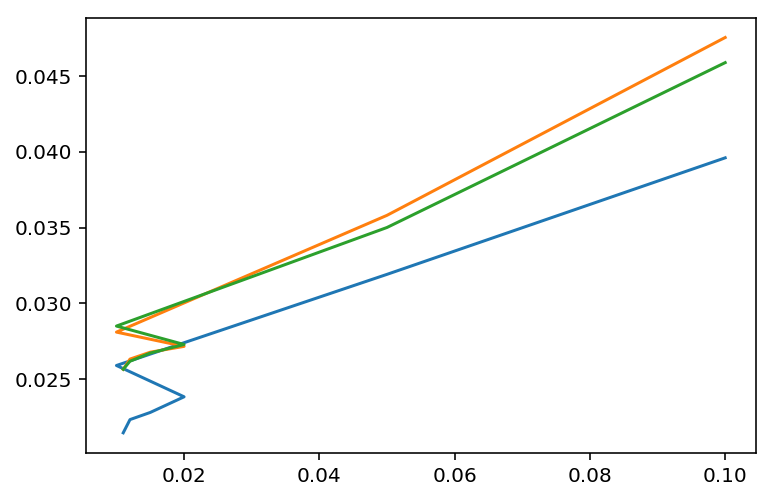

In [141]:
plt.plot(alphas,lassoModelCV.mse_path_)

In [144]:
lasso=Lasso(alpha=0.011).fit(new_X_train, y)

ids = test['Id']
ytspred=lasso.predict(new_X_test)
sale_prices = np.expm1(ytspred)

result = pd.DataFrame({ 'Id': ids, 'SalePrice': np.round(sale_prices, 3) })
display(result.head())

result.to_csv('submission.csv', header=['Id', 'SalePrice'], index=False)

,Id,SalePrice
0,1461,132566.040
1,1462,153865.057
2,1463,179536.938
3,1464,198679.688
4,1465,201288.733


### Lowest RMS Error: 0.12096 Score on Kaggle

### 3.10 : Things that worked and those that didn't

Stacking gave us better results as we're building upon the results of other models(Lasso and Ridge Regression).
However on tuning the parameters of XGBRegressor at one point the score got worse, possibly due to overfitting so we went back to the same model that gave us lower RMSE.

LassoCV ultimately gave us the best score after tuning alphas in the appropriate range.



### 3.8, 3.9 Some posts we liked and learned from:

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

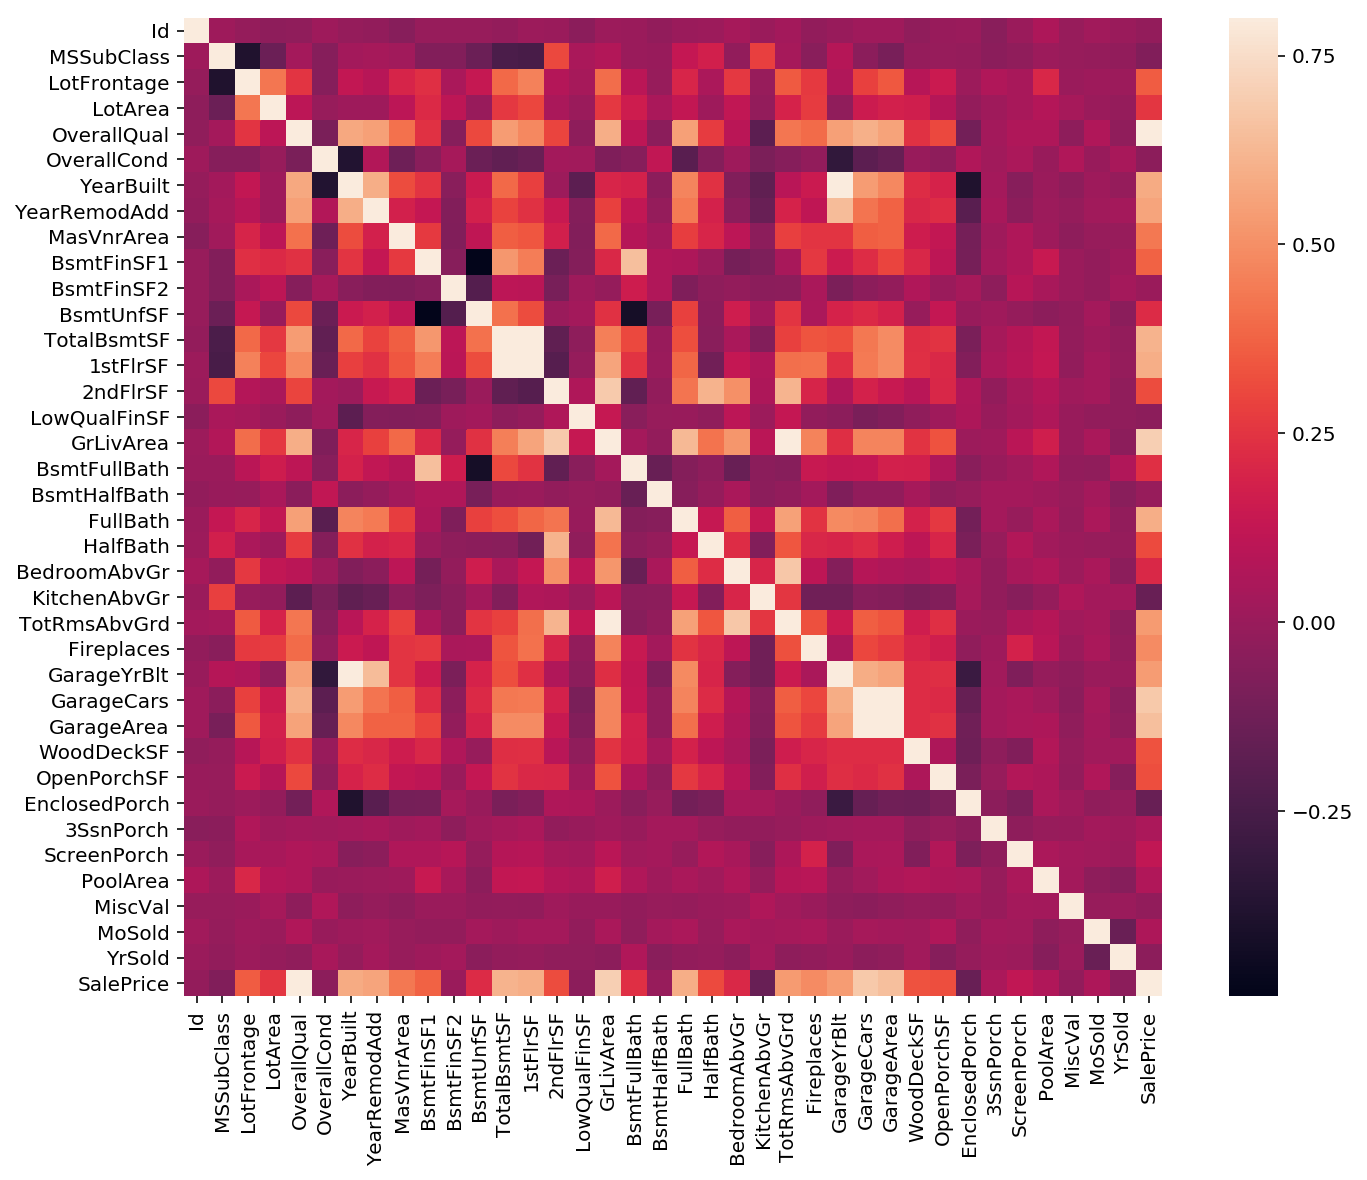

In [145]:
# Generating visual heatmap of correlations

corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

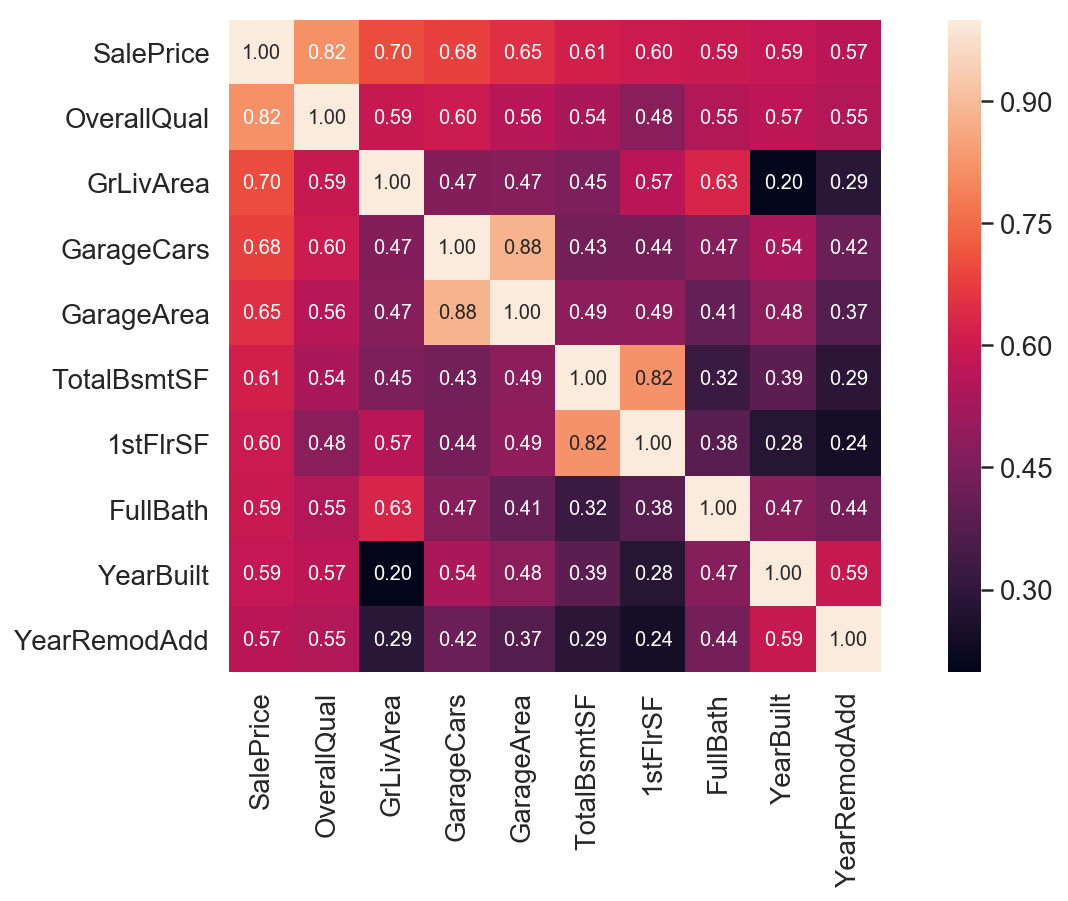

In [34]:
# Zoomed Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [37]:
# Removing Missing Data:

total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max()

0

In [38]:
df_train = pd.get_dummies(train)
df_train.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,978,0,284,...,0,0,0,1,0,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,0,0,1,0,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,0,0,1,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,655,0,490,...,0,0,0,1,0,0,0,0,1,0


#### Cross-validation

In [58]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [62]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

xgb3 = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



In [60]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1226 (0.0163)



In [63]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and wi

Xgboost score: 0.1227 (0.0103)



### <div align="center">The End</div>